In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", "DeprecationWarning")

In [2]:
lc_train = pd.read_csv('LC_train.csv')
lc_train.head(5)

,Student_IDs,Semester,Degree_Type,Class_Standing,Major,Expected_Graduation,Course_Name,Course_Number,Course_Type,Course_Code_by_Thousands,...,Check_In_Date,Check_In_Time,Check_Out_Time,Duration_In_Min,Gender,Term_Credit_Hours,Term_GPA,Total_Credit_Hours_Earned,Cumulative_GPA,Change_in_GPA
0,BGSU00006,Fall 2016,Undergraduate,Senior,No Response,Fall Semester 2017,Business Analytics III: Descriptive Analytics,STAT-2110,STAT,2000,...,9/13/16,13:21:00,15:32:00,131,FEMALE,6,2.5,105.0,3.265,-0.765
1,BGSU00006,Fall 2016,Undergraduate,Senior,No Response,Fall Semester 2017,Business Analytics III: Descriptive Analytics,STAT-2110,STAT,2000,...,8/31/16,09:32:00,10:59:00,86,FEMALE,6,2.5,105.0,3.265,-0.765
2,BGSU00006,Fall 2016,Undergraduate,Senior,No Response,Fall Semester 2017,Business Analytics III: Descriptive Analytics,STAT-2110,STAT,2000,...,9/2/16,09:31:00,10:37:00,66,FEMALE,6,2.5,105.0,3.265,-0.765
3,BGSU00009,Fall 2016,Undergraduate,Senior,"COMPSC-BS:Computer Science,SCIENC-MIN:Science",Fall Semester 2020,College Algebra I,MATH-1210,MATH,1000,...,12/1/16,13:24:00,17:02:00,217,MALE,7,3.0,155.0,2.180,0.820
4,BGSU00009,Fall 2016,Undergraduate,Senior,"COMPSC-BS:Computer Science,SCIENC-MIN:Science",Fall Semester 2020,College Algebra I,MATH-1210,MATH,1000,...,9/7/16,13:31:00,15:23:00,112,MALE,7,3.0,155.0,2.180,0.820


In [3]:
def map_to_stem_category(course_name):
    course_name_lower = course_name.lower()
    if any(keyword in course_name_lower for keyword in ['biology', 'chemistry', 'physics', 'science', 'research methods', 'methodology', 'earth', 'clinical', 'genetics', 'nutrition', 'neuro', 'anatomy', 'environmental', 
                                                        'Geology', 'solar', 'nursing', 'climate', 'laboratory', 'hydrology']):
        return 'Science'
    elif any(keyword in course_name_lower for keyword in ['programming', 'analytics', 'information', 'data', 'computer', 'computers', 'algorithms', 'game theory', 'operating systems', 'computing', 'windows application',]):
        return 'Technology'
    elif any(keyword in course_name_lower for keyword in ['engineering', 'constructors', 'bim', 'construction', 'mechanics', 'manufacturing', 'electrical', 'architecture', 'mechanical']):
        return 'Engineering'
    elif any(keyword in course_name_lower for keyword in ['algebra', 'calculus', 'mathematics', 'geometry', 'statistics', 'real analysis', 'equations', 'microeconomics', 'complex analysis', 'probability', ]):
        return 'Mathematics'
    else:
        return 'Non-STEM'
    
unique_courses = lc_train['Course_Name'].unique()
course_category_mapping = {course: map_to_stem_category(course) for course in unique_courses}
lc_train['course_category'] = lc_train['Course_Name'].map(map_to_stem_category)

In [4]:
lc_train.isna().sum()

Student_IDs                  0
Semester                     0
Degree_Type                  0
Class_Standing               0
Major                        0
Expected_Graduation          0
Course_Name                  0
Course_Number                0
Course_Type                  0
Course_Code_by_Thousands     0
Semester_Week                0
Check_In_Date                0
Check_In_Time                0
Check_Out_Time               0
Duration_In_Min              0
Gender                       0
Term_Credit_Hours            0
Term_GPA                     0
Total_Credit_Hours_Earned    0
Cumulative_GPA               0
Change_in_GPA                0
course_category              0
dtype: int64

In [5]:
### 
# Q1 = np.percentile(lc_train['Duration_In_Min'], 25, method='midpoint')
# Q3 = np.percentile(lc_train['Duration_In_Min'], 75, method='midpoint')
# IQR = Q3 - Q1

# upper = Q3 +1.5*IQR 


# lower = Q1 - 1.5*IQR 

# lc_train_no_outliers = lc_train[(lc_train['Duration_In_Min'] <= upper) & (lc_train['Duration_In_Min'] >= lower)]
# print(lc_train_no_outliers.shape)
# IQR, upper, lower

- Re-code the class standing variable to `academic standing` to remove the imbalancedness. 
- Check out the minimum `GPA` for good standing in both undergrad and grad. 

In [6]:
# lc_train_no_outliers.drop(columns=['Check_Out_Time', 'Student_IDs', 'Course_Name', 'Course_Type', 'Major', 'Course_Number', 'Degree_Type'], axis=1, inplace=True)
lc_train.drop(columns=['Check_Out_Time', 'Student_IDs', 'Course_Name', 'Course_Type', 'Major', 'Course_Number', 'Degree_Type'], axis=1, inplace=True)

In [7]:
def assign_time_bin(hour):
    if 0 <= hour < 6:
        return 'Early Morning'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'
    

def course_number_encode(course_number):
    num = int(course_number)
    if num < 1000:
        return "Unknown course number"
    elif 1000 <= num < 2000:
        return "Freshman level Course"
    elif 2000 <= num < 3000:
        return "Sophomore level Course"
    elif 3000 <= num < 4000:
        return "Junior level Course"
    elif 4000 <= num < 5000:
        return 'Senior level Course'
    else:
        return "Grad level Course"
    

def data_feature_encoding_method(df, Dtype = 'train'):
    data = df.copy()
    data['Check_In_Time'] = pd.to_datetime(data['Check_In_Time'], format='%H:%M:%S')
    data['hour'] = data['Check_In_Time'].dt.hour
    data['minute'] = data['Check_In_Time'].dt.minute

    # time encoding
    data['sin_hour'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['cos_hour'] = np.cos(2 * np.pi * data['hour'] / 24)   


    ## time bin and other 
    data['time_bin'] = data['hour'].apply(assign_time_bin)
    data['course_level'] = data['Course_Code_by_Thousands'].apply(course_number_encode)
    data.drop(columns=['Course_Code_by_Thousands'], axis=1, inplace=True)

    ## Date encoding
    data['Check_In_Date'] = pd.to_datetime(data['Check_In_Date'], format='%m/%d/%y')
    data['Day_Of_Week'] = data['Check_In_Date'].dt.dayofweek  # Monday=0, Sunday=6?
    data['Is_weekend'] = data['Day_Of_Week'].apply(lambda x: 1 if x >= 5 else 0)

    data.drop(columns=['Check_In_Date', 'Check_In_Time'], axis = 1, inplace= True)
    if Dtype == "test":
        return data
    return data.drop(columns=['Duration_In_Min'], axis=1), data['Duration_In_Min']

In [8]:
X, y_duration_in_minutes = data_feature_encoding_method(lc_train)

catgorical_columns  = list(X.select_dtypes(include=['object', 'category']).columns)
numerical_columns  = list(X.select_dtypes(include=['int', 'float']).columns)
catgorical_columns, numerical_columns

(['Semester',
  'Class_Standing',
  'Expected_Graduation',
  'Gender',
  'course_category',
  'time_bin',
  'course_level'],
 ['Semester_Week',
  'Term_Credit_Hours',
  'Term_GPA',
  'Total_Credit_Hours_Earned',
  'Cumulative_GPA',
  'Change_in_GPA',
  'hour',
  'minute',
  'sin_hour',
  'cos_hour',
  'Day_Of_Week',
  'Is_weekend'])

In [9]:
encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
encoder.fit(X[catgorical_columns])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [10]:
## Number of fitted catergorical columns
encoder.get_feature_names_out().shape[0]

28

In [11]:
## All data 
X_encoded = encoder.transform(X[catgorical_columns])
X_encoded_final = np.hstack([X_encoded, X[numerical_columns].values])

In [12]:
X_encoded_final.shape, y_duration_in_minutes.shape

((11735, 40), (11735,))

### Model Training

In [13]:
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=2.0),
    "Lasso Regression": Lasso(alpha=0.3),
    "KNN Regression": KNeighborsRegressor(n_neighbors=5),
    "ElasticNet Regression": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Principal Component Regression": Pipeline([
        ('scaler', StandardScaler()),  # Standardize features
        ('pca', PCA(n_components=5)),  # Reduce dimensionality
        ('regressor', LinearRegression())
    ]),
    "Partial Least Squares Regression": PLSRegression(n_components=5),
    # "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    # "XGBoost Regressor": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
}
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [14]:
results = {}

best_model = None
best_cv_score = float('inf')
for model_name, model in models.items():
    # Cross-validation with RMSE
    cv_score = -1 * cross_val_score(
        model, X_encoded_final, y_duration_in_minutes.values, 
        cv=kf, scoring=rmse_scorer
    ).mean()
    results[model_name] = cv_score 
    if best_cv_score > cv_score: ## lower rmse matters here
        best_model = model
        best_cv_score = cv_score

In [15]:
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Mean RMSE'])
results_df = results_df.sort_values(by='Mean RMSE')

results_df.head(10)

,Mean RMSE
Ridge Regression,60.699492
Linear Regression,60.701832
Partial Least Squares Regression,61.095180
Lasso Regression,61.097137
ElasticNet Regression,61.144895
Principal Component Regression,61.703308
KNN Regression,65.134278


In [16]:
print("Best Model Chosen: ", best_model)

Best Model Chosen:  Ridge(alpha=2.0)


## Refit the best model

In [17]:
ridge_score = -1 * cross_val_score(best_model, X_encoded_final, y_duration_in_minutes.values, cv=kf, scoring=rmse_scorer).mean()
ridge_score

60.699492130737596

In [18]:
X_encoded_final.shape

(11735, 40)

In [19]:
## Reft the best model all data 
best_model_duration_in_Min = best_model
best_model_duration_in_Min.fit(X_encoded_final, y_duration_in_minutes.values)

Ridge(alpha=2.0)

### Prediction on all data.

In [20]:
def process_predict_data(data):
    data['course_category'] = data['Course_Name'].map(map_to_stem_category)
    data.drop(columns=['Student_IDs', 'Course_Name', 'Course_Type', 'Major', 'Course_Number', 'Degree_Type'], axis=1, inplace=True)

    data = data_feature_encoding_method(data, Dtype='test')

    catgorical_columns  = list(data.select_dtypes(include=['object', 'category']).columns)
    numerical_columns  = list(data.select_dtypes(include=['int', 'float']).columns)


    encoded_test = encoder.transform(data[catgorical_columns])
    encoded_final = np.hstack([encoded_test, data[numerical_columns].values])

    return encoded_final



test_data = pd.read_csv('./LC_test.csv')
test_data = process_predict_data(test_data)

/usr/local/Caskroom/miniforge/base/envs/ds-programming/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [21]:
test_data.shape

(13143, 40)

In [22]:
duration_in_minutes = np.round(best_model_duration_in_Min.predict(test_data), 2)
duration_in_minutes[:10]

array([71.46, 91.66, 86.13, 86.25, 86.8 , 85.1 , 90.06, 87.14, 91.39,
       86.14])

In [23]:
# pd.DataFrame({"Duration_In_Minutes": list(duration_in_minutes)}).to_csv('./duration_in_minutes_predictions.csv', index=False)

In [24]:
# residuals = test_labels.values - np.exp(y_pred)

### OCCUPANCY

In [25]:
lc_train_df = pd.read_csv('LC_train.csv')


lc_train_df['course_category'] = lc_train_df['Course_Name'].map(map_to_stem_category)

warnings.filterwarnings('ignore')

occupancy = []
df = lc_train_df.copy()
df['Check_In_DateTime'] = pd.to_datetime(df['Check_In_Date'] + ' ' + df['Check_In_Time'])
df['Check_Out_DateTime'] = pd.to_datetime(df['Check_In_Date'] + ' ' + df['Check_Out_Time'])
for i, row in df.iterrows():
    count = ((df['Check_In_DateTime'] <= row['Check_In_DateTime']) & 
             (df['Check_Out_DateTime'] > row['Check_In_DateTime'])).sum()
    occupancy.append(count)

#df['Occupancy-2'] = occupancy
occupancy[:6]

[5, 3, 3, 16, 12, 17]

In [26]:
df.drop(columns=['Check_Out_Time', 'Student_IDs', 'Course_Name', 'Course_Type', 'Major', 'Course_Number', 'Degree_Type'], axis=1, inplace=True)

In [27]:
train_data, _ = data_feature_encoding_method(df)
train_data.head()

,Semester,Class_Standing,Expected_Graduation,Semester_Week,Gender,Term_Credit_Hours,Term_GPA,Total_Credit_Hours_Earned,Cumulative_GPA,Change_in_GPA,...,Check_In_DateTime,Check_Out_DateTime,hour,minute,sin_hour,cos_hour,time_bin,course_level,Day_Of_Week,Is_weekend
0,Fall 2016,Senior,Fall Semester 2017,4,FEMALE,6,2.5,105.0,3.265,-0.765,...,2016-09-13 13:21:00,2016-09-13 15:32:00,13,21,-0.258819,-0.965926,Afternoon,Sophomore level Course,1,0
1,Fall 2016,Senior,Fall Semester 2017,2,FEMALE,6,2.5,105.0,3.265,-0.765,...,2016-08-31 09:32:00,2016-08-31 10:59:00,9,32,0.707107,-0.707107,Morning,Sophomore level Course,2,0
2,Fall 2016,Senior,Fall Semester 2017,2,FEMALE,6,2.5,105.0,3.265,-0.765,...,2016-09-02 09:31:00,2016-09-02 10:37:00,9,31,0.707107,-0.707107,Morning,Sophomore level Course,4,0
3,Fall 2016,Senior,Fall Semester 2020,15,MALE,7,3.0,155.0,2.180,0.820,...,2016-12-01 13:24:00,2016-12-01 17:02:00,13,24,-0.258819,-0.965926,Afternoon,Freshman level Course,3,0
4,Fall 2016,Senior,Fall Semester 2020,3,MALE,7,3.0,155.0,2.180,0.820,...,2016-09-07 13:31:00,2016-09-07 15:23:00,13,31,-0.258819,-0.965926,Afternoon,Freshman level Course,2,0


In [28]:
train_data.drop(columns=['Check_Out_DateTime', 'Check_In_DateTime'], axis=1, inplace=True)
train_data.columns

Index(['Semester', 'Class_Standing', 'Expected_Graduation', 'Semester_Week',
       'Gender', 'Term_Credit_Hours', 'Term_GPA', 'Total_Credit_Hours_Earned',
       'Cumulative_GPA', 'Change_in_GPA', 'course_category', 'hour', 'minute',
       'sin_hour', 'cos_hour', 'time_bin', 'course_level', 'Day_Of_Week',
       'Is_weekend'],
      dtype='object')

In [ ]:
def preprocess_categorical_variables(data):
    df = data.copy()
    cat_cols = list(df.select_dtypes(include = ['object', 'category']))
    num_cols = list(df.select_dtypes(include = ['int', 'float']))

    encoded_variables = encoder.transform(df[cat_cols]) ## same encoder from the duration in minutes
    return  np.hstack([encoded_variables, df[num_cols].values])

train_data_ = preprocess_categorical_variables(train_data)

In [30]:
train_data_.shape, lc_train.shape

((11735, 40), (11735, 15))

In [31]:
y_occupancy = occupancy
len(y_occupancy)

11735

In [32]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm

class PoissonRegressor(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.model = None
    
    def fit(self, X, y):
        X = sm.add_constant(X)  # Add intercept
        self.model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
        return self
    
    def predict(self, X):
        X = sm.add_constant(X)
        return self.model.predict(X)

# Add Poisson Regression to models
models["Poisson Regression"] = PoissonRegressor()

In [33]:
def run_cross_validation(models, X_train, train_labels):
    results = {}
    best_model_ = None
    best_cv_score_ = float('inf')
    for model_name, model in models.items():
        # Cross-validation with RMSE
        cv_score = -1 * cross_val_score(
            model, X_train, train_labels, 
            cv=kf, scoring=rmse_scorer
        ).mean()
        results[model_name] = cv_score
        if best_cv_score_ > cv_score: # lower rmse matters here
            best_model_ = model
            best_cv_score_ = cv_score

    results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Mean RMSE'])
    print(best_cv_score_)

    return results_df.sort_values(by='Mean RMSE'), best_model_

In [34]:
### Cross val score
occupancy_res, best_model_occupancy = run_cross_validation(models, train_data_, y_occupancy)
occupancy_res.head()

4.988804520409663


,Mean RMSE
Ridge Regression,4.988805
Linear Regression,4.988996
Poisson Regression,5.001576
Partial Least Squares Regression,5.014622
ElasticNet Regression,5.085225


In [35]:
best_model_occupancy.fit(train_data_, y_occupancy)

Ridge(alpha=2.0)

In [36]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(best_model_occupancy.predict(train_data_), y_occupancy))

4.973051217394813

In [37]:
predicted_occupancy = best_model_occupancy.predict(test_data)
predicted_occupancy[:10]

array([12.85888364, 16.81350673, 12.28107233, 12.32023438, 12.24632691,
       12.50632804, 15.83268366,  6.68866545, 16.45716079,  6.567646  ])

In [38]:
# pd.DataFrame({'Occupancy': np.round(predicted_occupancy)}).to_csv('./predicted_occupancy.csv', index=False)

##### Residual Analysis

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def residual_analysis(y_true, y_pred):
    """
    Perform residual analysis for a regression model.
    
    Parameters:
    - y_true: Array-like, true target values.
    - y_pred: Array-like, predicted values from the model.
    
    Returns:
    - None. Displays residual analysis plots.
    """
    # residuals
    residuals = y_true - y_pred
    residuals = np.array(residuals)
    residuals = residuals[np.isfinite(residuals)]
    
    # subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.4)
    
    ### 1. Residuals vs Predicted Values (Randomness and Constant Variance)
    axes[0, 0].scatter(y_pred, residuals, alpha=0.7, edgecolor='k')
    axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[0, 0].set_title("Residuals vs Predicted Values")
    axes[0, 0].set_xlabel("Predicted Values")
    axes[0, 0].set_ylabel("Residuals")
    axes[0, 0].grid(True)
    
    ### 2. Residuals Histogram (Mean ~ 0 Check)
    sns.histplot(residuals, kde=True, ax=axes[0, 1], color='red')
    axes[0, 1].axvline(0, color='skyblue', linestyle='--', linewidth=2)
    axes[0, 1].set_title("Histogram of Residuals")
    axes[0, 1].set_xlabel("Residuals")
    axes[0, 1].set_ylabel("Frequency")
    axes[0, 1].grid(True)
    
    ### 3. Residuals vs Observation Order (Independence Check)
    axes[1, 0].plot(residuals, marker='o', linestyle='', alpha=0.7)
    axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 0].set_title("Residuals vs Observation Order")
    axes[1, 0].set_xlabel("Observation Order")
    axes[1, 0].set_ylabel("Residuals")
    axes[1, 0].grid(True)
    
    ### 4. Q-Q Plot (Normality Check)
    stats.probplot(residuals, dist="norm", plot=axes[1, 1])
    axes[1, 1].get_lines()[1].set_color('red')  # Set trend line to red
    axes[1, 1].set_title("Q-Q Plot of Residuals")
    
    plt.tight_layout()
    plt.show()

#### Resduals Duraton In Minutes

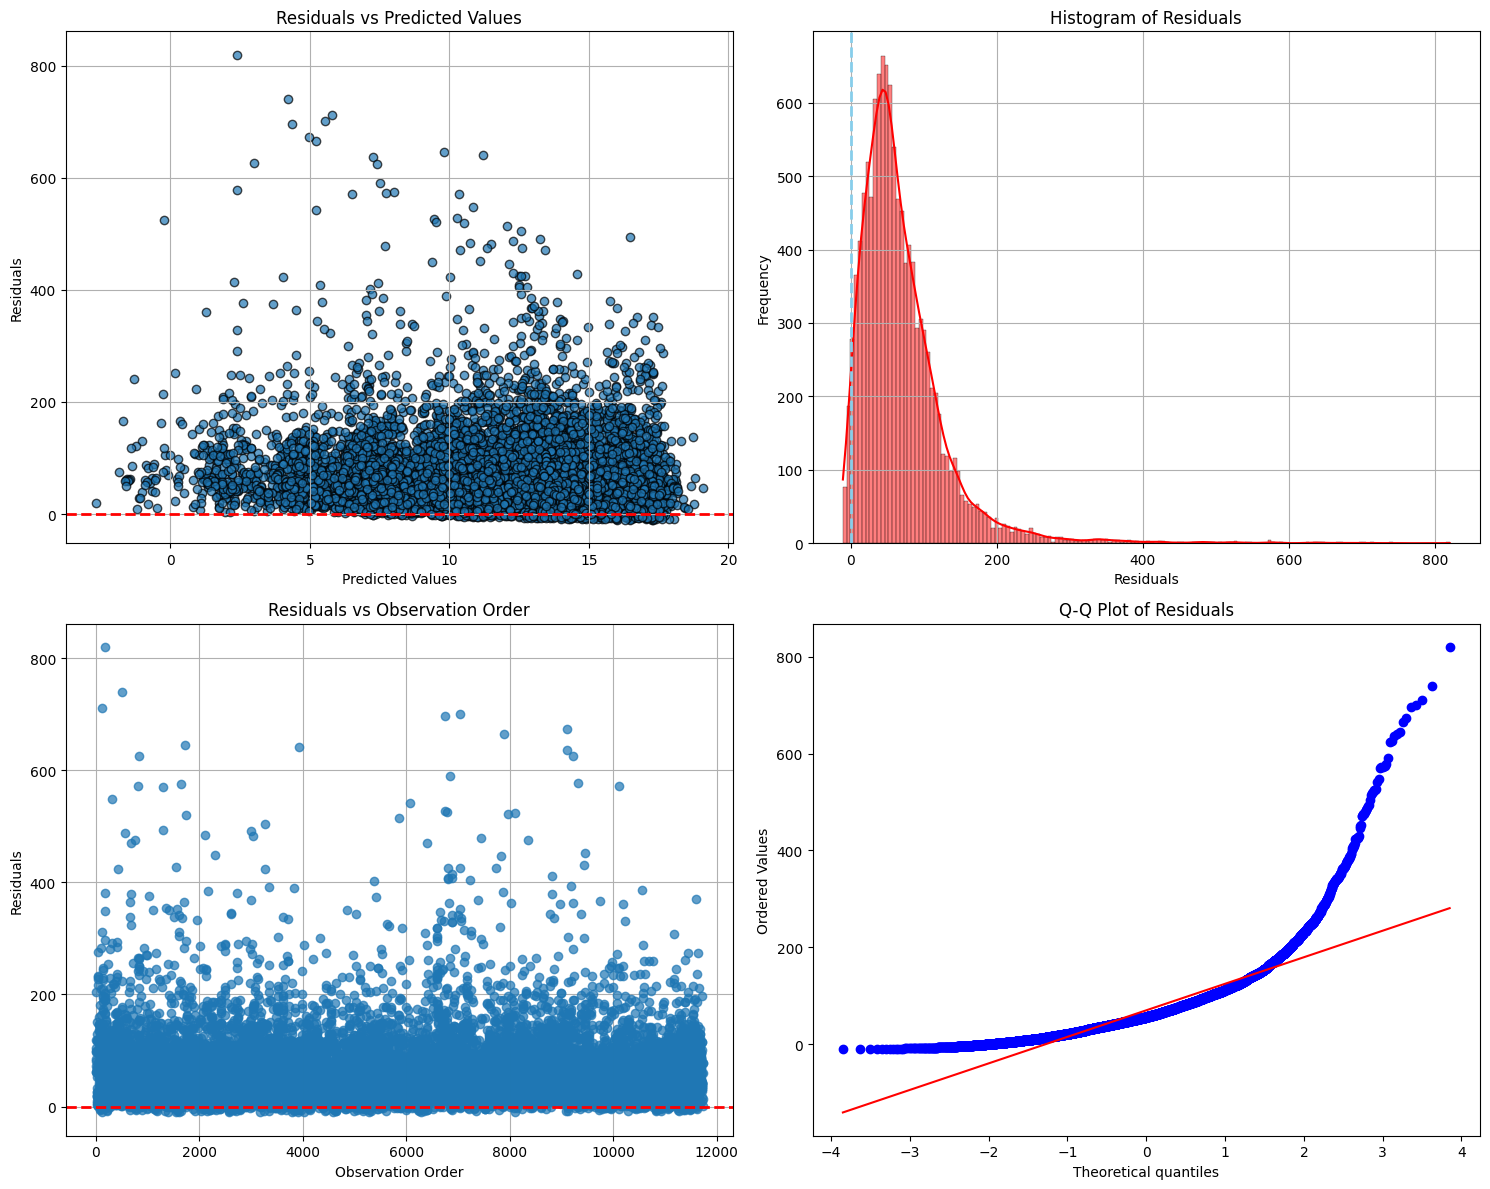

In [40]:
duration_preds = best_model.predict(X_encoded_final)
residual_analysis(y_true=y_duration_in_minutes,
                  y_pred=duration_preds)

##### Residuals Occupancy

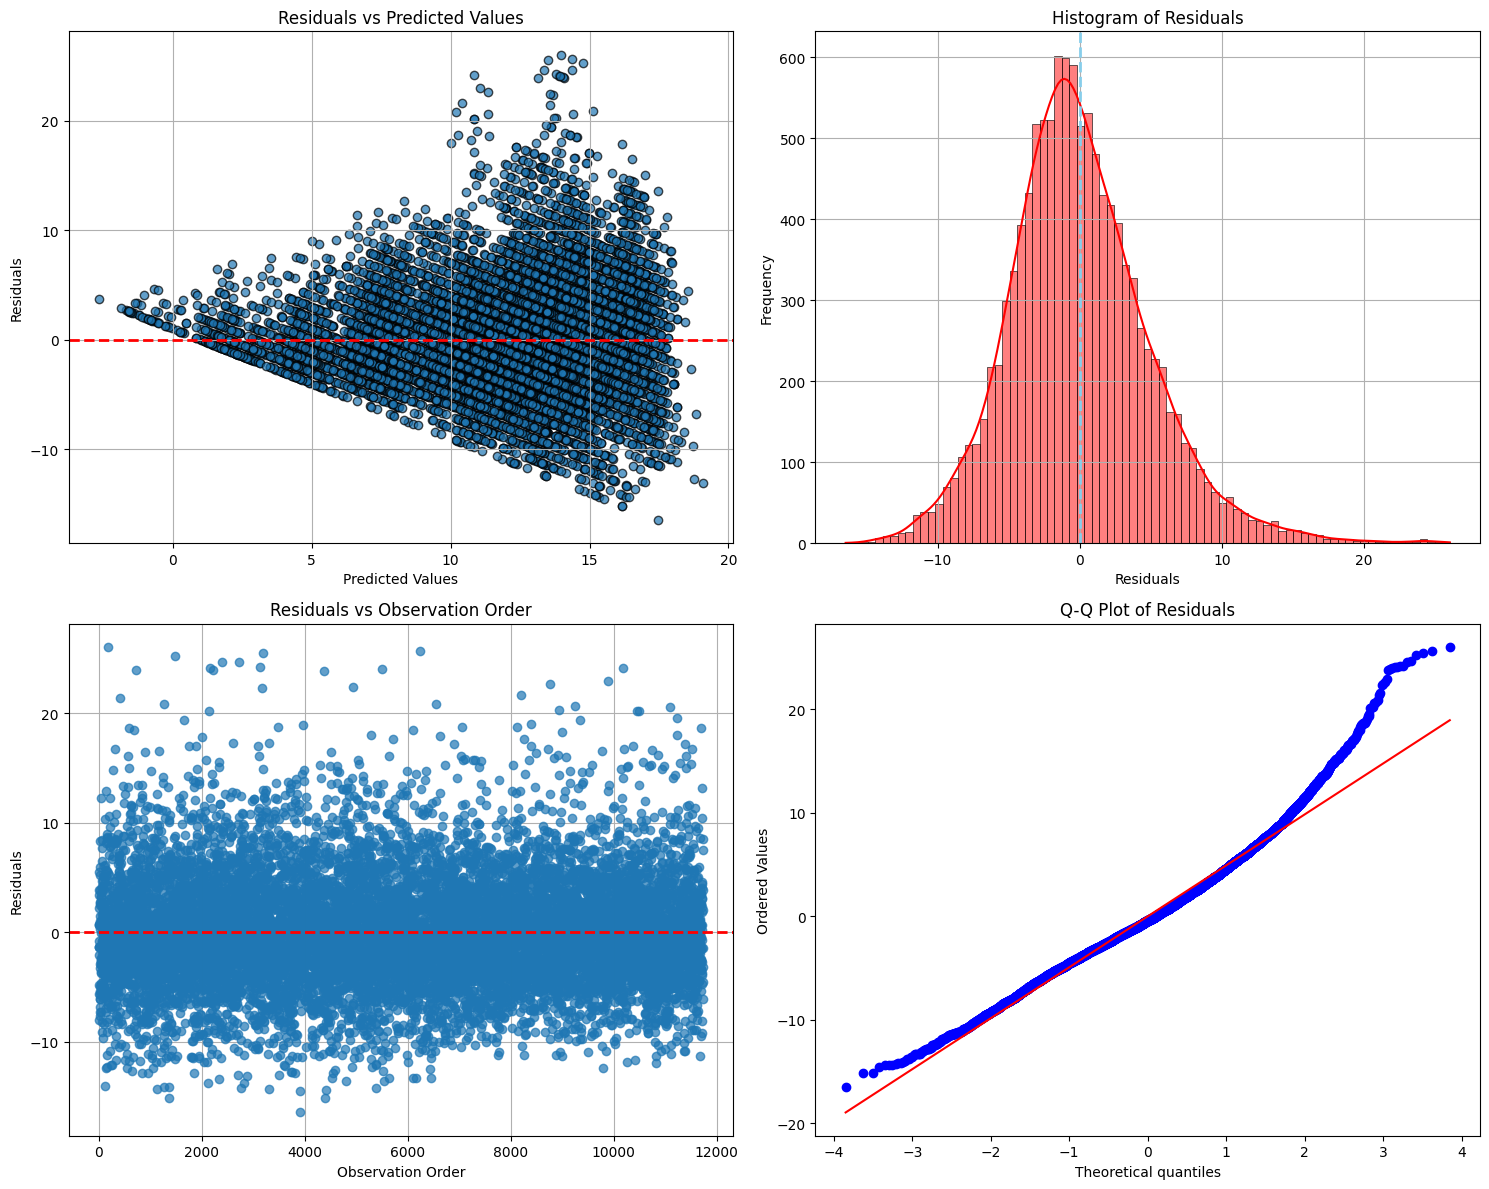

In [41]:
occupncy_preds = best_model_occupancy.predict(train_data_)
residual_analysis(y_true=y_occupancy,
                  y_pred=occupncy_preds)

##### Variable Importance

In [54]:
feature_names = encoder.get_feature_names_out().tolist() + numerical_columns

In [64]:
def plot_linear_importance(model, feature_names, absolute = False):
    """
    Plot feature importance for linear regression models.
    
    Parameters:
    - model: Trained linear regression model (e.g., sklearn LinearRegression, Ridge, etc.)
    - feature_names: List of feature names.
    
    Returns:
    - None. Displays the feature importance plot.
    """
    if absolute:
        coef = model.coef_
        importance = np.abs(coef) # just absolute importance
    else:
        importance = model.coef_
    
    ## DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel("Importance (Absolute Coefficient Value)")
    plt.ylabel("Feature")
    plt.title("Variable Importance for Ridge Regression")
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.show()

### Duration in Minutes Feature Importance

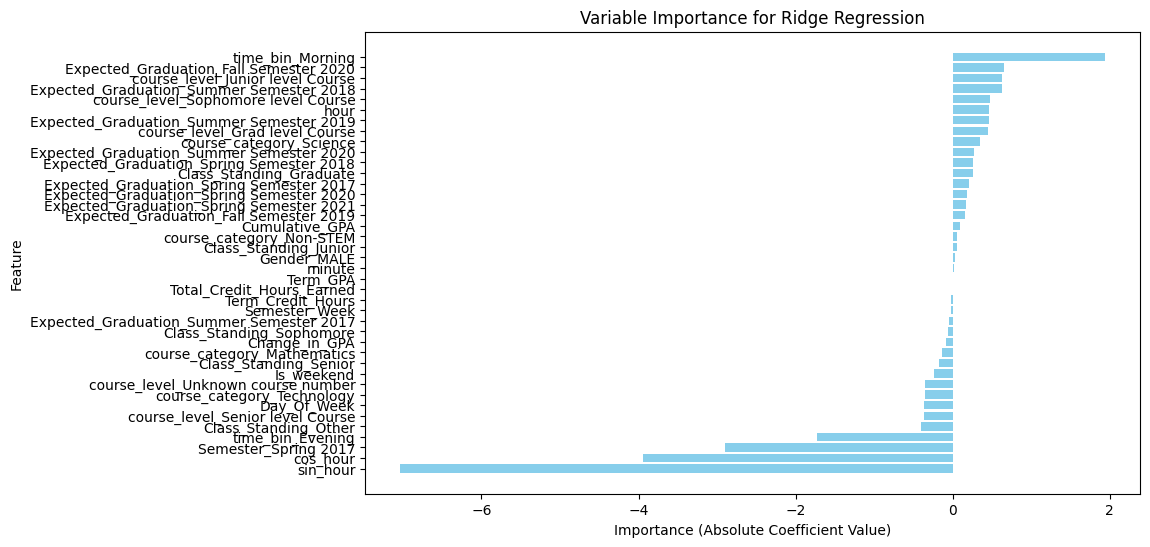

In [65]:
## Directional importance 
plot_linear_importance(model=best_model_duration_in_Min, 
                       feature_names=feature_names)

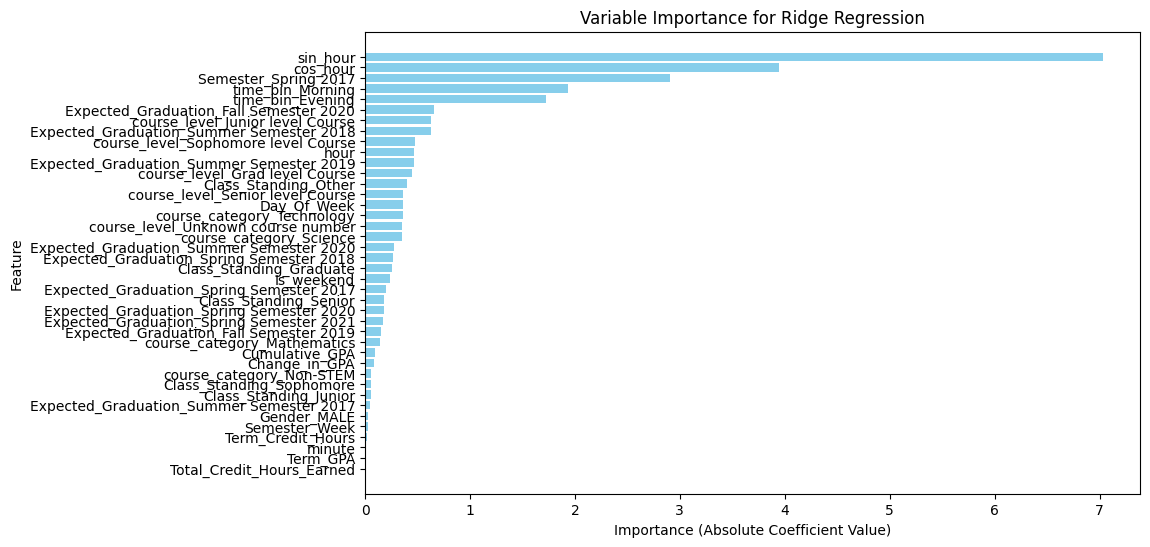

In [66]:
## Absolute importance 
plot_linear_importance(model=best_model_duration_in_Min, 
                       feature_names=feature_names, absolute = True)

### Occupancy Feature Importance

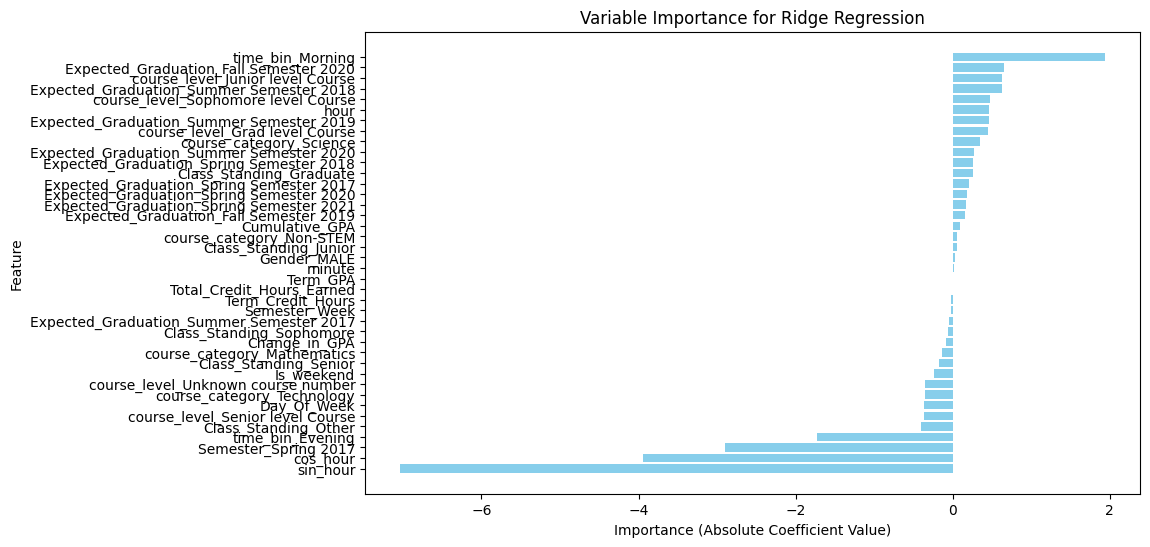

In [67]:
## Directional importance 
plot_linear_importance(model=best_model_occupancy, 
                       feature_names=feature_names, absolute = False)

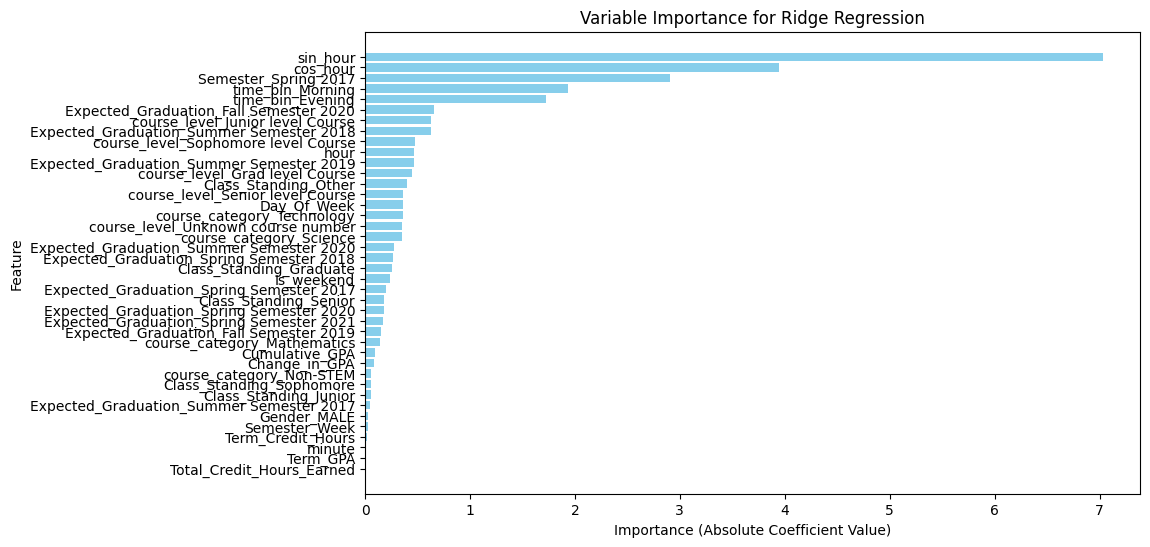

In [68]:
## Absolute importance 
plot_linear_importance(model=best_model_occupancy, 
                       feature_names=feature_names, absolute = True)

In [42]:
break here 

SyntaxError: invalid syntax (3512612220.py, line 1)

## MLP FIT

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded_final, y.values, test_size=0.2, random_state=42)

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
X_test_tensor.size()

torch.Size([2347, 36])

In [ ]:
class MLPRegression(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegression, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Output layer
        )
    
    def forward(self, x):
        return self.model(x)
    
input_dim = X_train.shape[1]
model = MLPRegression(input_dim)


def rmse_loss(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2))

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Training loop
num_epochs = 100
batch_size = 32
train_size = X_train_tensor.size(0)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    # Mini-batch training
    for i in range(0, train_size, batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]
        
        # Forward pass
        predictions = model(X_batch)
        loss = rmse_loss(predictions, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/train_size:.4f}")

Epoch [10/100], Loss: 1.8833
Epoch [20/100], Loss: 1.8772
Epoch [30/100], Loss: 1.8753
Epoch [40/100], Loss: 1.8743
Epoch [50/100], Loss: 1.8737
Epoch [60/100], Loss: 1.8732
Epoch [70/100], Loss: 1.8727
Epoch [80/100], Loss: 1.8724
Epoch [90/100], Loss: 1.8722
Epoch [100/100], Loss: 1.8720


In [ ]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 57.6546


### How about cross-validation?

In [ ]:
X_tensor = torch.tensor(X_encoded_final, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

In [ ]:
# Training and evaluation function
def train_and_evaluate(model, train_idx, val_idx, X_tensor, y_tensor, num_epochs=100, batch_size=32, lr=0.01):
    # Split data into training and validation sets
    X_train, y_train = X_tensor[train_idx], y_tensor[train_idx]
    X_val, y_val = X_tensor[val_idx], y_tensor[val_idx]
    
    # Optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_size = X_train.size(0)
    
    # Training loop
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for i in range(0, train_size, batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # Forward pass
            predictions = model(X_batch)
            loss = rmse_loss(predictions, y_batch)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val)
        val_rmse = torch.sqrt(torch.mean((val_predictions - y_val) ** 2)).item()
    return val_rmse

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_rmse = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):
    print(f"Fold {fold + 1}")
    model = MLPRegression(input_dim=X_tensor.size(1))  # Create a new model for each fold
    fold_rmse.append(train_and_evaluate(model, train_idx, val_idx, X_tensor, y_tensor))
    print(f"Fold {fold + 1} RMSE: {fold_rmse[-1]:.4f}")

# Average RMSE across folds
print(f"Average RMSE: {np.mean(fold_rmse):.4f}")

Fold 1
Fold 1 RMSE: 58.5243
Fold 2
Fold 2 RMSE: 65.2137
Fold 3
Fold 3 RMSE: 68.6517
Fold 4
Fold 4 RMSE: 60.9604
Fold 5
Fold 5 RMSE: 62.2576
Average RMSE: 63.1216
